<div style = "text-align:center; font-size: 28px; font-weight: bold;"> Predictive Service Delay Management for CTA Trains</div>
<br>


This notebook reflects the necessary steps taken to arrive at a functioning predictive model for the Chicago Transit Authority (CTA).

### Import Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE


### Import the Dataset

The dataset is based on real-time data, and is sourced from two separate APIs, the CTA Train Tracker API, and TomTom's Traffic Flow RESTful API.

In [2]:
# The dataset has no column headers, so we are applying column labels based on the API script used to scrape the data
column_labels = [
    "station_id", "line", "predicted_time", "arrival_time", 
    "isSch", "isFlt", "isDly", 
    "station_name", "destination_name", "lat", "long", 
    "free_flow_speed", "current_speed"
]

df = pd.read_csv("combined_data.csv", header = None, names = column_labels)

In [3]:
df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
89340,40670,Blue,20230817 18:45:16,20230817 18:52:16,0,0,0,Western (O'Hare Branch),LaSalle (Jksn for FP),41.94031,-87.71245,58,21
17549,40190,Red,20230810 16:45:59,20230810 16:52:59,0,0,0,Sox-35th,Howard,41.78054,-87.63100,71,71
48653,40890,Blue,20230811 13:26:56,20230811 13:40:56,0,0,0,O'Hare,O'Hare,41.98244,-87.78510,63,18
101516,40700,G,20230819 18:30:25,20230819 19:18:25,0,0,0,Laramie,Harlem/Lake,41.78022,-87.61070,23,23
104019,41170,Red,20230819 19:06:48,20230819 19:13:48,0,0,0,Garfield,95th/Dan Ryan,41.85321,-87.63097,10,3


Some of these column headers may be hard to decipher. Let's clarify what they mean.

Per the CTA Train Tracker API:

**predicted_time** = "Date-time format stamp for when the prediction was generated:
yyyyMMdd HH:mm:ss (24-hour format, time local to Chicago)"

**arrival_time** = "Date-time format stamp for when a train is expected to arrive/depart:
yyyyMMdd HH:mm:ss (24-hour format, time local to Chicago)"

**isSch** = "Boolean flag to indicate whether this is a live prediction or based on
schedule in lieu of live data"

**isFlt** = "Boolean flag to indicate whether a potential fault has been detected"

>"The **isFlt** element in the results indicates what we call a “schedule fault” in the context of Train Tracker.
A fault on an ETA that is schedule-based (isSch=1) indicates that the scheduled arrival time given
might not be feasible to serve due to the lack of a scheduled departure having occurred."

**isDly** = "Boolean flag to indicate whether a train is considered “delayed” in Train
Tracker"

**lat** = "Latitude position of the train in decimal degrees"

**long** = "Longitude position of the train in decimal degrees"

Per TomTom's Traffic Flow RESTful API:

**free_flow_speed** = "The free flow speed expected under ideal conditions, expressed in [MPH]

**current_speed** = "The current average speed at the selected [latitude and longitude], in [MPH]."

>Note that these speeds fetched from the TomTom API *do not* directly refer to the train itself; they are not train speeds. Rather, they are referring to the *traffic speeds* of the roads closest to the geographical coordinates of the specifc train.

<div style = "text-align:center; font-size: 24px; font-weight: bold;"> Exploratory Data Analysis (EDA)</div>


### The Basics

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113190 entries, 0 to 113189
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   station_id        113190 non-null  int64  
 1   line              113190 non-null  object 
 2   predicted_time    113190 non-null  object 
 3   arrival_time      113190 non-null  object 
 4   isSch             113190 non-null  int64  
 5   isFlt             113190 non-null  int64  
 6   isDly             113190 non-null  int64  
 7   station_name      113190 non-null  object 
 8   destination_name  113190 non-null  object 
 9   lat               113190 non-null  float64
 10  long              113190 non-null  float64
 11  free_flow_speed   113190 non-null  int64  
 12  current_speed     113190 non-null  int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 11.2+ MB


In [5]:
top_stations = df['station_id'].value_counts().nlargest(20)

bottom_stations = df['station_id'].value_counts().nsmallest(20)

print("Most frequent stations in this dataset:", top_stations, sep="\n\n")

print(" ")

print("Least frequent stations in this dataset:", bottom_stations, sep="\n\n")

Most frequent stations in this dataset:

40040    1939
40260    1849
40160    1847
40170    1693
40380    1589
40080    1500
40190    1488
40330    1448
40680    1438
40460    1396
40730    1361
40850    1274
40090    1273
40240    1272
40120    1242
40210    1229
40150    1227
40100    1227
40530    1226
40030    1192
Name: station_id, dtype: int64
 
Least frequent stations in this dataset:

40810      1
41680     28
41380     61
40140    126
41250    268
40920    282
41050    285
40980    289
40970    290
41140    298
40840    344
40690    348
40720    365
40940    377
40520    378
40390    408
40400    422
40900    428
40250    445
40180    448
Name: station_id, dtype: int64


### Delays

From the points of clarity earlier, we can make several observations.
First, let's see how many **already-classified delays** there are in this dataset.

In [6]:
df['isDly'].value_counts()

0    112627
1       563
Name: isDly, dtype: int64

Out of **110699** total train-tracking instances in this dataset, only **555** of them are **delay-positive**. 

Per the CTA Train Tracker API documentation:

>"The CTA Train Tracker service looks at how long it’s been since a train has moved from one track
circuit to the next and identifies delays if a train appears to not be moving."

Next, let's see how many instances are based on schedule or have a potential fault. 

In [7]:
df['isSch'].value_counts()

0    113190
Name: isSch, dtype: int64

In [8]:
df['isFlt'].value_counts()

0    113190
Name: isFlt, dtype: int64

Out of the entire dataset, every train so far is based on live predictions and has not had a fault. 

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now, let's return to delays, and analyze them further. Let's see how many recorded delays there are for every specific line.  </div>

>For those who are not native to Chicago, the city's train system consists of multiple colored lines, each of which is associated with a color name.

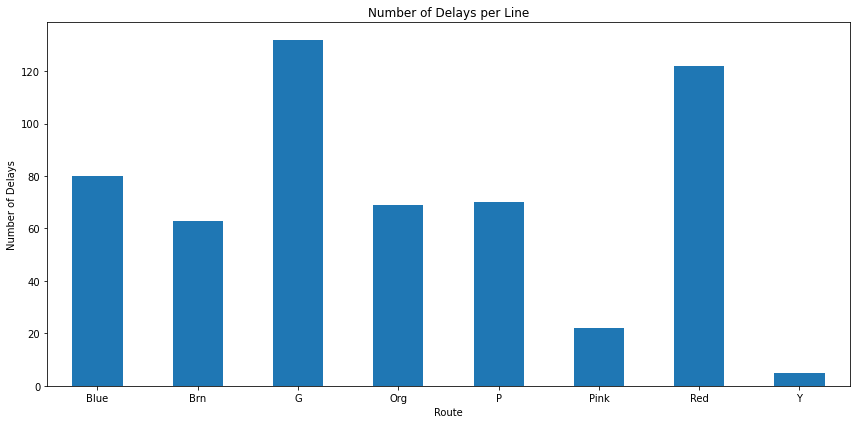

In [9]:
route_delay_counts = df.groupby('line')['isDly'].sum()

plt.figure(figsize = (12,6))
route_delay_counts.plot(kind = 'bar')
plt.xlabel('Route')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per Line')
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()


It seems the Green Line (G) has the most delays out of all the lines. 

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now let's analyze delays per station. </div>

Station ID with the most delays: 40100
Delay count: 13


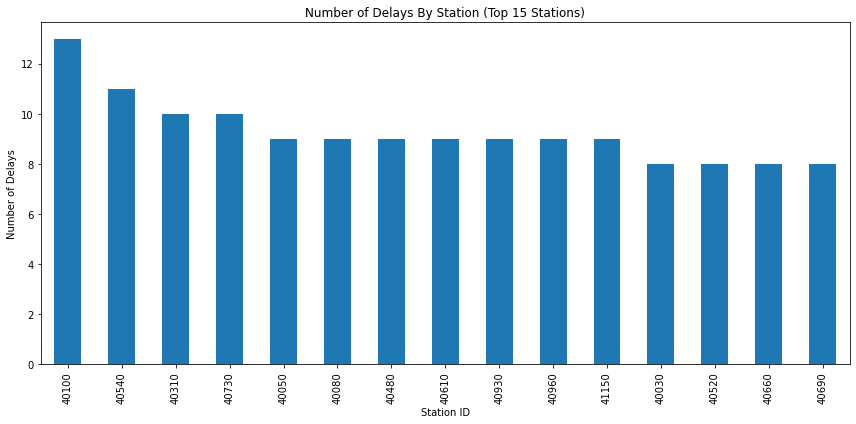

In [10]:
station_delay_counts = df.groupby('station_id')['isDly'].sum()

most_delay_station = station_delay_counts.idxmax()

most_delay_station

most_delay_count = station_delay_counts.loc[most_delay_station]

print("Station ID with the most delays:", most_delay_station)
print("Delay count:", most_delay_count)

#------------------------------------------------------------------

top_n = 15
top_delay_stations = station_delay_counts.nlargest(top_n).index

plt.figure(figsize = (12,6))
station_delay_counts.loc[top_delay_stations].plot(kind = 'bar', stacked = True)
plt.xlabel('Station ID')
plt.ylabel('Number of Delays')
plt.title(f"Number of Delays By Station (Top {top_n} Stations)")
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

<div style = "text-align:left; font-size: 18px; font-weight: normal;"> Now let's look at delays per hour. </div>

In [11]:
# Convert 'predicted_time' to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])

# Create a list of all hours (0 to 23)
all_hours = list(range(24))

# Create a DataFrame with all hours
hourly_delays = pd.DataFrame({'hour_of_day': all_hours})

# Merge the original data with the all hours DataFrame to count delays for each hour
hourly_delays = hourly_delays.merge(df.groupby(df['predicted_time'].dt.hour)['isDly'].sum().reset_index(), 
                                    how = 'left', left_on = 'hour_of_day', right_on = 'predicted_time')

# Fill NaN values with 0 (no delays)
hourly_delays['isDly'] = hourly_delays['isDly'].fillna(0).astype(int)

# Drop the redundant 'predicted_time' column
hourly_delays.drop(columns=['predicted_time'], inplace = True)

# Rename columns
hourly_delays.columns = ['hour_of_day', 'number_of_delays']

# Print the new DataFrame
hourly_delays

,hour_of_day,number_of_delays
0,0,21
1,1,25
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


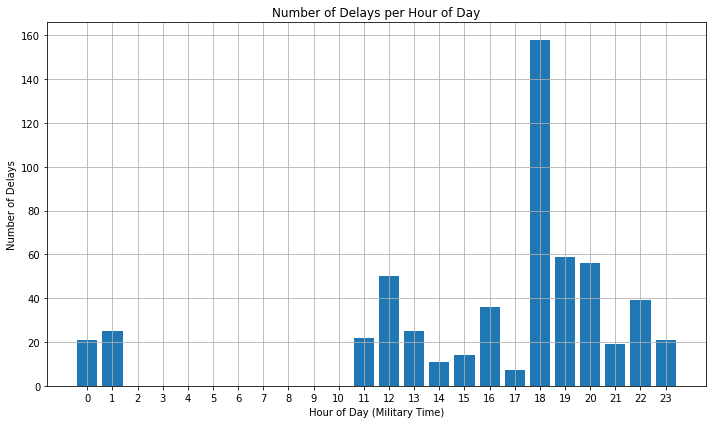

In [12]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_delays['hour_of_day'], hourly_delays['number_of_delays'])
plt.xlabel('Hour of Day (Military Time)')
plt.ylabel('Number of Delays')
plt.title('Number of Delays per Hour of Day')
plt.xticks(all_hours)
plt.grid(True)
plt.tight_layout()
plt.show()

It seems 6 pm is when delays are most frequent.

<div style="text-align:center; font-size: 24px; font-weight: bold;"> Data Preprocessing </div>
<br style="line-height: 3px;">
<div style="text-align:center; font-size: 18px; font-weight: bold;"> Feature Engineering (Wait Times and Lateness) </div>

To gain further insight into the characteristics of train delays, we can **engineer new columns** that can potentially enhance the predictive power of our machine learning model.

For instance, logically, the difference between **the time a particular prediction is generated** for when a train would arrive ('predicted_time' column), and **the time for when the train is predicted to arrive** ('arrival_time'), can be understood as time an individual would have to wait until the train arrives onto the platform, otherwise known as the **wait time**.

However, recall that, from the CTA Train Tracker API documentation:

>"The CTA Train Tracker service looks at how long it’s been since a train has moved from one track circuit to the next and identifies delays if a train appears to not be moving."

IMPORTANT: In this way, you can understand "delayed" trains as a *technical indicator*, where the train is at a standstill, and "late" trains as a *time-based indicator*, meaning that the train is traveling, but just from farther away.

With that being said, let's make a new column for how long the wait will be. We can call this new column, "wait_minutes".

In [13]:
# Convert 'predicted_time' and 'arrival_time' columns to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])
df['arrival_time'] = pd.to_datetime(df['arrival_time'])

# Calculate the difference between 'arrival_time' and 'predicted_time' in minutes
df['wait_minutes'] = (df['arrival_time'] - df['predicted_time']).dt.total_seconds() / 60

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'arrival_time'
arrival_time_index = column_names.index('arrival_time')

# Move 'wait_minutes' right after 'arrival_time'
column_names.insert(arrival_time_index + 1, column_names.pop(column_names.index('wait_minutes')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
62822,40530,Brn,2023-08-11 19:50:19,2023-08-11 20:02:19,12.0,0,0,0,Diversey,Kimball,41.89460,-87.63563,11,11
23108,41070,G,2023-08-10 18:05:16,2023-08-10 18:22:16,17.0,0,0,0,Kedzie,Harlem/Lake,41.87024,-87.62672,13,13
56917,41320,Red,2023-08-11 16:28:42,2023-08-11 16:30:42,2.0,0,0,0,Belmont,95th/Dan Ryan,41.94743,-87.65363,12,9
20264,40830,Pink,2023-08-10 17:29:40,2023-08-10 17:49:40,20.0,0,0,0,18th,54th/Cermak,41.88262,-87.62617,11,8
7708,41040,Pink,2023-08-10 14:47:41,2023-08-10 14:48:41,1.0,0,0,0,Kedzie,54th/Cermak,41.85419,-87.70163,19,16


Now, we have the wait time (in minutes) for every instance of a train-arrival prediction. Next, let's get the **average wait time for every train station**, and name the column 'station_avg_wait'.

In [14]:
# Group the data by 'station_id' and calculate the average delay time for each station
df['station_avg_wait'] = df.groupby('station_id')['wait_minutes'].transform('mean')

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'wait_minutes'
wait_minutes_index = column_names.index('wait_minutes')

# Move 'station_avg_wait' right after 'wait_minutes'
column_names.insert(wait_minutes_index + 1, column_names.pop(column_names.index('station_avg_wait')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
88984,40220,Blue,2023-08-16 22:43:18,2023-08-16 22:54:18,11.0,10.270925,0,0,0,Western (Forest Park Branch),IMD (for O'Hare),41.87151,-87.75276,63,63
70533,40730,Brn,2023-08-12 00:45:50,2023-08-12 01:14:50,29.0,13.674504,0,0,0,Washington/Wells,Kimball,41.96630,-87.68601,17,17
4929,41690,G,2023-08-10 13:51:42,2023-08-10 14:10:42,19.0,16.013699,0,0,0,Cermak-McCormick Place,Harlem/Lake,41.78032,-87.63207,24,17
27551,40080,Red,2023-08-10 18:54:58,2023-08-10 18:59:58,5.0,16.792000,0,0,0,Sheridan,Howard,41.93799,-87.65334,14,14
50182,40590,Blue,2023-08-11 13:43:57,2023-08-11 13:45:57,2.0,13.483395,0,0,0,Damen,O'Hare,41.90092,-87.66274,18,14


Awesome. Now we have the wait time of every individual train-arrival prediction, compared to the average wait time for train-arrival predictions in the corresponding train stations. 

Below is a visual of this comparison for any station of interest. Simply run the cell and provide an station ID input.

List of unique station IDs:
[40260 40380 41700 40680 40850 40160 40040 40730 40460 40330 41400 41160
 41220 41120 41320 40820 40960 41020 40910 40740 40310 40670 40220 41480
 41080 41230 41130 41000 41690 41450 40710 40490 41060 40190 40170 40320
 40660 40830 40210 40120 40590 40530 41070 41040 41150 41170 40510 40250
 40540 41500 40150 40030 40550 40880 40240 40070 40560 40010 40020 40050
 40060 40080 40090 40100 40130 40180 40230 40270 40280 40290 40300 40360
 40370 40390 40400 40420 40440 40450 40480 40520 40570 40580 40600 40610
 40630 40650 40690 40700 40720 40750 40760 40780 40790 40800 40840 40870
 40890 40900 40920 40930 40940 40970 40980 40990 41010 41030 41050 41090
 41140 41180 41190 41200 41210 41240 41250 41260 41270 41280 41290 41300
 41310 41330 41350 41360 41380 41410 41420 41430 41440 41460 41490 41510
 41660 41670 40140 41680 40810]

Enter a station ID from the selection above to plot its 'wait_minutes' distribution: 40140


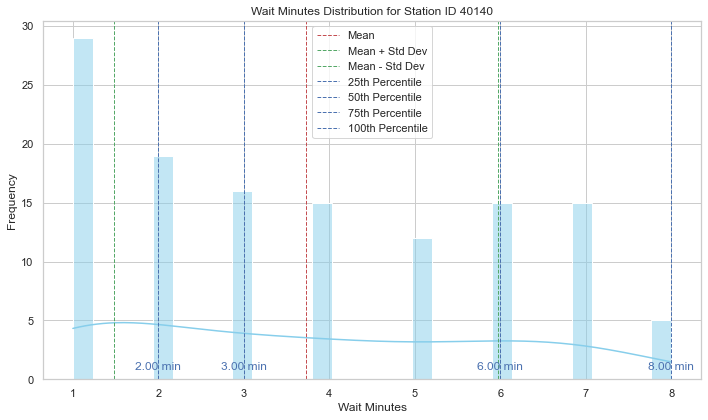

Average wait time: 3.73 minutes
Standard deviation of wait time: 2.25 minutes


In [15]:
# Get the list of unique station IDs
unique_stations = df['station_id'].unique()

print("List of unique station IDs:")
print(unique_stations)

# Prompt the user to input a station ID
station_id_input = int(input("\nEnter a station ID from the selection above to plot its 'wait_minutes' distribution: "))

# Filter the DataFrame for the selected station ID
selected_station_df = df[df['station_id'] == station_id_input]

# Calculate mean and standard deviation of wait_minutes for the selected station
mean_wait = selected_station_df['wait_minutes'].mean()
std_wait = selected_station_df['wait_minutes'].std()

# Calculate percentiles
percentiles = [25, 50, 75, 100]
percentile_values = np.percentile(selected_station_df['wait_minutes'], percentiles)

# Set the Seaborn style
sns.set(style="whitegrid")

# Create the distribution plot using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=selected_station_df, x='wait_minutes', bins=30, kde=True, color = 'skyblue')
plt.axvline(mean_wait, color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(mean_wait + std_wait, color='g', linestyle='dashed', linewidth=1, label='Mean + Std Dev')
plt.axvline(mean_wait - std_wait, color='g', linestyle='dashed', linewidth=1, label='Mean - Std Dev')

# Add percentile indicators
for p, value in zip(percentiles, percentile_values):
    plt.axvline(value, color='b', linestyle='dashed', linewidth=1, label=f'{p}th Percentile')
    plt.annotate(f'{value:.2f} min', (value, 0), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12, color='b')

plt.xlabel('Wait Minutes')
plt.ylabel('Frequency')
plt.title(f'Wait Minutes Distribution for Station ID {station_id_input}')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Average wait time: {mean_wait:.2f} minutes")
print(f"Standard deviation of wait time: {std_wait:.2f} minutes")

The logic follows that, any instance that has a wait time above the 75th percentile of all recorded wait times of the corresponding train station can be classified as a "**late**" train.
>The 75th percentile of wait times, calculated for each station, serves as a robust threshold for identifying lateness. By using the 75th percentile, we capture instances where the wait time is higher than most occurrences.This approach accounts for variations in station-specific wait time distributions and avoids being overly sensitive to outliers or temporary fluctuations.

So, we will make a new column called 'isLte' to indicate whether a train is late or not.

In [16]:
# Calculate the 75th percentile of wait_minutes for each station
station_75th_percentile = df.groupby('station_id')['wait_minutes'].quantile(0.75)

# Create a new column 'isLte' based on whether wait_minutes is above the 75th percentile
df['isLte'] = df.apply(lambda row: int(row['wait_minutes'] >= station_75th_percentile[row['station_id']]), axis=1)

# Get the list of column names from the DataFrame
column_names = df.columns.tolist()

# Find the index of 'station_avg_wait'
SAW_index = column_names.index('station_avg_wait')

# Move 'isLte' right after 'station_avg_wait'
column_names.insert(SAW_index + 1, column_names.pop(column_names.index('isLte')))

# Reorder the DataFrame columns
df = df[column_names]

df.sample(n = 5)

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
37466,40080,Red,2023-08-10 23:14:09,2023-08-10 23:29:09,15.0,16.792000,0,0,0,0,Sheridan,95th/Dan Ryan,42.00566,-87.66565,22,22
2550,40170,Pink,2023-08-10 12:12:22,2023-08-10 12:22:22,10.0,10.733018,0,0,0,0,Ashland,54th/Cermak,41.87691,-87.62820,10,6
27861,40370,Blue,2023-08-10 19:07:59,2023-08-10 19:20:59,13.0,20.330155,0,0,0,0,Washington,Forest Park,41.92084,-87.69506,16,13
36663,40130,G,2023-08-10 23:01:30,2023-08-10 23:13:30,12.0,21.530648,0,0,0,0,51st,Ashland/63rd,41.80209,-87.61850,23,23
66885,40760,Red,2023-08-11 21:23:11,2023-08-11 21:28:11,5.0,21.645788,0,0,0,0,Granville,Howard,41.99366,-87.65920,19,15


Let's fully analyze late trains in this dataset, in the same way we did with delays.

In [17]:
df['isLte'].value_counts()

0    83476
1    29714
Name: isLte, dtype: int64

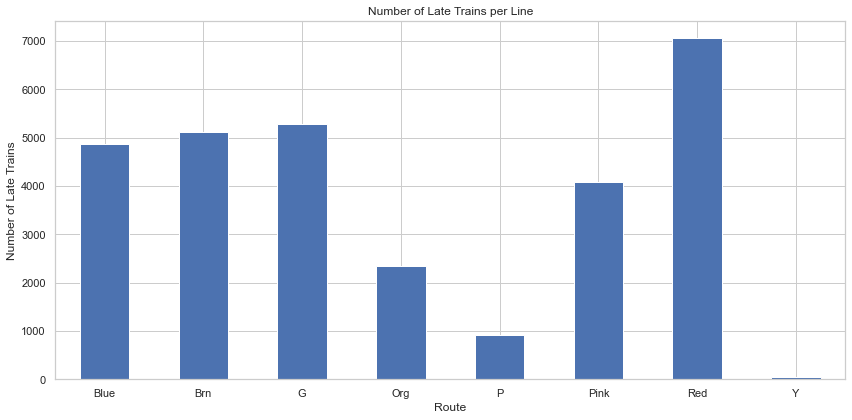

In [18]:
route_late_counts = df.groupby('line')['isLte'].sum()

plt.figure(figsize=(12, 6))
route_late_counts.plot(kind='bar')
plt.xlabel('Route')
plt.ylabel('Number of Late Trains')
plt.title('Number of Late Trains per Line')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Station ID with the most late trains: 40040
Late train count: 539


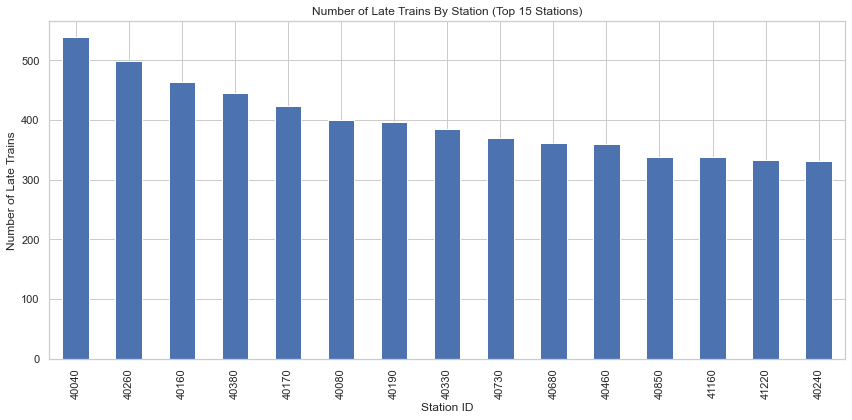

In [19]:
# Group the data by 'station_id' and calculate the sum of 'isLte' for each station
station_late_counts = df.groupby('station_id')['isLte'].sum()

# Find the station with the most late trains
most_late_station = station_late_counts.idxmax()
most_late_count = station_late_counts.loc[most_late_station]

print("Station ID with the most late trains:", most_late_station)
print("Late train count:", most_late_count)

# Get the top N stations with the most late trains
top_n = 15
top_late_stations = station_late_counts.nlargest(top_n).index

# Create a bar plot to visualize the number of late trains by station
plt.figure(figsize=(12, 6))
station_late_counts.loc[top_late_stations].plot(kind='bar', stacked=True)
plt.xlabel('Station ID')
plt.ylabel('Number of Late Trains')
plt.title(f"Number of Late Trains By Station (Top {top_n} Stations)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [20]:
# Convert 'predicted_time' to datetime
df['predicted_time'] = pd.to_datetime(df['predicted_time'])

# Create a list of all hours (0 to 23)
all_hours = list(range(24))

# Create a DataFrame with all hours
hourly_lates = pd.DataFrame({'hour_of_day': all_hours})

# Merge the original data with the all hours DataFrame to count late trains for each hour
hourly_lates = hourly_lates.merge(df.groupby(df['predicted_time'].dt.hour)['isLte'].sum().reset_index(), 
                                  how='left', left_on='hour_of_day', right_on='predicted_time')

# Fill NaN values with 0 (no late trains)
hourly_lates['isLte'] = hourly_lates['isLte'].fillna(0).astype(int)

# Drop the redundant 'predicted_time' column
hourly_lates.drop(columns=['predicted_time'], inplace=True)

# Rename columns
hourly_lates.columns = ['hour_of_day', 'number_of_late_trains']

# Print the new DataFrame
hourly_lates


,hour_of_day,number_of_late_trains
0,0,1011
1,1,757
2,2,152
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


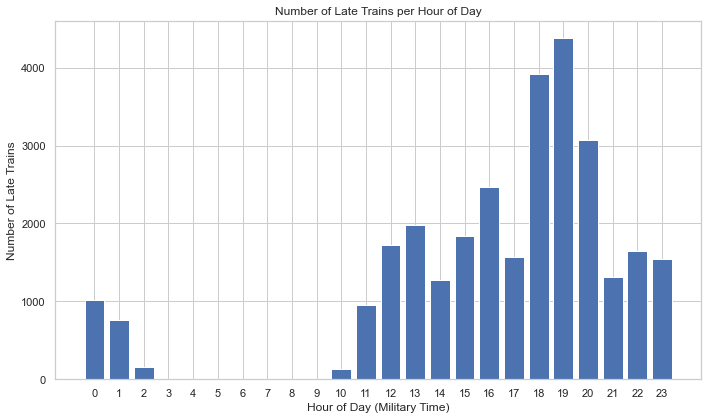

In [21]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_lates['hour_of_day'], hourly_lates['number_of_late_trains'])
plt.xlabel('Hour of Day (Military Time)')
plt.ylabel('Number of Late Trains')
plt.title('Number of Late Trains per Hour of Day')
plt.xticks(all_hours)
plt.grid(True)
plt.tight_layout()
plt.show()

It appears that we have **28,575** instances of late trains. Let's see how many of these instances of late trains correspond to actual delayed trains.

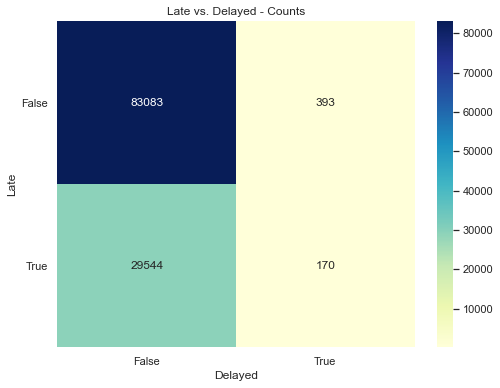

In [22]:
# Create a crosstab table
cross_table = pd.crosstab(df['isLte'], df['isDly'])

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cross_table, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Delayed')
plt.ylabel('Late')
plt.title('Late vs. Delayed - Counts')
plt.xticks([0.5, 1.5], ['False', 'True'], rotation = 0)
plt.yticks([0.5, 1.5], ['False', 'True'], rotation = 0)
plt.show()

In [23]:
# Calculate the correlation between 'isLte' and 'isDly' columns
correlation = df['isLte'].corr(df['isDly'])

print("Correlation between isLte and isDly:", correlation)

Correlation between isLte and isDly: 0.006337392585424063


The cross table and Pearson correlation coefficient suggests to us that there is no linear relationship between the occurence of late trains and delayed trains in the dataset. We will return to these features later.

<div style="text-align:center; font-size: 18px; font-weight: bold;"> Feature Engineering (Nearby Traffic) </div>

In [24]:
df.head()

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed
0,40260,G,2023-08-09 23:47:29,2023-08-09 23:51:29,4.0,8.383991,0,0,0,0,State/Lake,Harlem/Lake,41.87360,-87.62679,15,15
1,40260,Org,2023-08-09 23:47:41,2023-08-09 23:51:41,4.0,8.383991,0,0,0,0,State/Lake,Midway,41.87734,-87.63369,14,14
2,40260,Pink,2023-08-09 23:47:26,2023-08-09 23:54:26,7.0,8.383991,0,0,0,0,State/Lake,54th/Cermak,41.88574,-87.62758,11,11
3,40260,G,2023-08-09 23:47:39,2023-08-09 23:56:39,9.0,8.383991,0,0,0,0,State/Lake,Ashland/63rd,41.88436,-87.69232,21,21
4,40260,Org,2023-08-09 23:47:33,2023-08-10 00:06:33,19.0,8.383991,1,0,0,0,State/Lake,Midway,41.83957,-87.66485,65,65


Now we will take a look at the columns 'free_flow_speed' and 'current_speed', and engineer a new column from the two, titled 'nearby_traffic'.

Reminder: 

Per TomTom's Traffic Flow RESTful API:

**free_flow_speed** = "The free flow speed expected under ideal conditions, expressed in [MPH]

**current_speed** = "The current average speed at the selected [latitude and longitude], in [MPH]."

>Note that these speeds fetched from the TomTom API *do not* directly refer to the train itself; they are not train speeds. Rather, they are referring to the *traffic speeds* of the roads closest to the geographical coordinates of the specifc train.

By subtracting 'current_speed' from 'free_flow_speed', if we get any number other than 0, that indicates that there is some level of congestion in the nearby roads.

In [25]:
# Calculate the difference between 'free_flow_speed' and 'current_speed'
df['nearby_traffic'] = (df['free_flow_speed'] - df['current_speed']).apply(lambda x: 1 if x != 0 else 0)

df.sample(n = 5, random_state = 42)

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed,nearby_traffic
18550,40570,Blue,2023-08-10 16:56:11,2023-08-10 17:21:11,25.0,11.687419,1,0,0,0,California,Forest Park,41.92194,-87.69689,17,13,1
85882,40890,Blue,2023-08-15 23:00:31,2023-08-15 23:01:31,1.0,22.679612,0,0,0,0,O'Hare,O'Hare,41.97706,-87.88979,47,47,0
69597,40420,Pink,2023-08-11 22:41:20,2023-08-11 23:20:20,39.0,27.317954,0,0,0,0,Cicero,54th/Cermak,41.88531,-87.66697,19,19,0
68766,41270,G,2023-08-11 22:05:46,2023-08-11 22:44:46,39.0,19.620295,1,0,0,0,43rd,Ashland/63rd,41.88739,-87.76565,21,17,1
12931,41050,P,2023-08-10 15:44:02,2023-08-10 16:02:02,18.0,21.589474,0,0,0,0,Linden,Linden,42.00121,-87.66122,19,12,1


In [26]:
df['nearby_traffic'].value_counts()

0    58289
1    54901
Name: nearby_traffic, dtype: int64

In [27]:
# Create a DataFrame with all hours
hourly_traffic = pd.DataFrame({'hour_of_day': all_hours})

# Merge the original data with the all hours DataFrame to count traffic instances for each hour
hourly_traffic = hourly_traffic.merge(df.groupby(df['predicted_time'].dt.hour)['nearby_traffic'].sum().reset_index(), 
                                      how='left', left_on='hour_of_day', right_on='predicted_time')

# Fill NaN values with 0 (no traffic)
hourly_traffic['nearby_traffic'] = hourly_traffic['nearby_traffic'].fillna(0).astype(int)

# Drop the redundant 'predicted_time' column
hourly_traffic.drop(columns=['predicted_time'], inplace=True)

# Rename columns
hourly_traffic.columns = ['hour_of_day', 'instances_of_nearby_traffic']

# Print the new DataFrame
hourly_traffic

,hour_of_day,instances_of_nearby_traffic
0,0,180
1,1,109
2,2,7
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


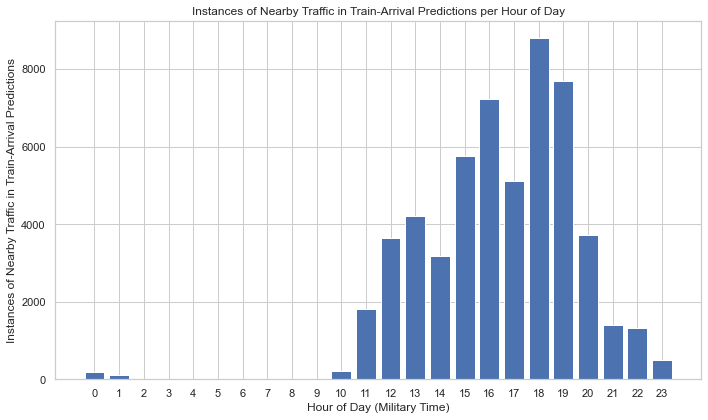

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(hourly_traffic['hour_of_day'], hourly_traffic['instances_of_nearby_traffic'])
plt.xlabel('Hour of Day (Military Time)')
plt.ylabel('Instances of Nearby Traffic in Train-Arrival Predictions')
plt.title('Instances of Nearby Traffic in Train-Arrival Predictions per Hour of Day')
plt.xticks(all_hours)
plt.grid(True)
plt.tight_layout()
plt.show()

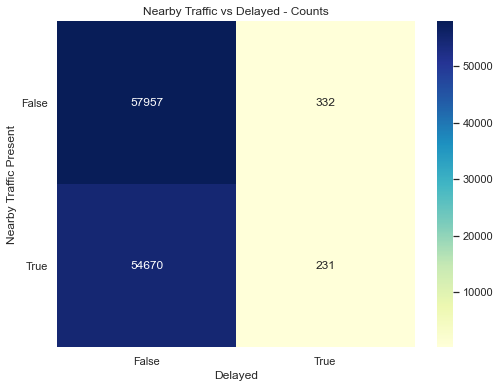

In [29]:
# Create a crosstab table
cross_table = pd.crosstab(df['nearby_traffic'], df['isDly'])

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cross_table, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Delayed')
plt.ylabel('Nearby Traffic Present')
plt.title('Nearby Traffic vs Delayed - Counts')
plt.xticks([0.5, 1.5], ['False', 'True'], rotation = 0)
plt.yticks([0.5, 1.5], ['False', 'True'], rotation = 0)
plt.show()

In [30]:
# Calculate the correlation between 'isLte' and 'isDly' columns
correlation = df['nearby_traffic'].corr(df['isDly'])

print("Correlation between nearby_traffic and isDly:", correlation)

Correlation between nearby_traffic and isDly: -0.010572179349007553


The cross table and Pearson correlation coefficient suggests to us that there is no linear relationship between the occurence of nearby traffic and delayed trains in the dataset. We will return to these features later.

In [31]:
# Extract the hour from 'predicted_time' and create a new column 'hour_of_day'
df['hour_of_day'] = df['predicted_time'].dt.hour

df

,station_id,line,predicted_time,arrival_time,wait_minutes,station_avg_wait,isLte,isSch,isFlt,isDly,station_name,destination_name,lat,long,free_flow_speed,current_speed,nearby_traffic,hour_of_day
0,40260,G,2023-08-09 23:47:29,2023-08-09 23:51:29,4.0,8.383991,0,0,0,0,State/Lake,Harlem/Lake,41.87360,-87.62679,15,15,0,23
1,40260,Org,2023-08-09 23:47:41,2023-08-09 23:51:41,4.0,8.383991,0,0,0,0,State/Lake,Midway,41.87734,-87.63369,14,14,0,23
2,40260,Pink,2023-08-09 23:47:26,2023-08-09 23:54:26,7.0,8.383991,0,0,0,0,State/Lake,54th/Cermak,41.88574,-87.62758,11,11,0,23
3,40260,G,2023-08-09 23:47:39,2023-08-09 23:56:39,9.0,8.383991,0,0,0,0,State/Lake,Ashland/63rd,41.88436,-87.69232,21,21,0,23
4,40260,Org,2023-08-09 23:47:33,2023-08-10 00:06:33,19.0,8.383991,1,0,0,0,State/Lake,Midway,41.83957,-87.66485,65,65,0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113185,40900,P,2023-08-21 02:33:51,2023-08-21 02:41:51,8.0,7.231308,0,0,0,0,Howard,Loop,42.06659,-87.68708,22,22,0,2
113186,40900,P,2023-08-21 02:34:21,2023-08-21 02:42:21,8.0,7.231308,0,0,0,0,Howard,Loop,42.07315,-87.69073,26,26,0,2
113187,40900,Red,2023-08-21 02:36:12,2023-08-21 02:50:12,14.0,7.231308,1,0,0,0,Howard,Howard,42.01906,-87.67289,16,16,0,2
113188,40900,Red,2023-08-21 02:35:56,2023-08-21 03:22:56,47.0,7.231308,1,0,0,0,Howard,Howard,41.83119,-87.63064,67,67,0,2


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113190 entries, 0 to 113189
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   station_id        113190 non-null  int64         
 1   line              113190 non-null  object        
 2   predicted_time    113190 non-null  datetime64[ns]
 3   arrival_time      113190 non-null  datetime64[ns]
 4   wait_minutes      113190 non-null  float64       
 5   station_avg_wait  113190 non-null  float64       
 6   isLte             113190 non-null  int64         
 7   isSch             113190 non-null  int64         
 8   isFlt             113190 non-null  int64         
 9   isDly             113190 non-null  int64         
 10  station_name      113190 non-null  object        
 11  destination_name  113190 non-null  object        
 12  lat               113190 non-null  float64       
 13  long              113190 non-null  float64       
 14  free

<div style="text-align:center; font-size: 18px; font-weight: bold;"> Dropping Unwanted Columns Before Training the Model </div>

In [33]:
# List of columns to drop
columns_to_drop = ['isSch', 'isFlt', 'lat', 'long', 'station_name', 'destination_name', 'predicted_time', 'arrival_time']

# Drop the specified columns from the DataFrame
df2 = df.drop(columns=columns_to_drop)

df2

,station_id,line,wait_minutes,station_avg_wait,isLte,isDly,free_flow_speed,current_speed,nearby_traffic,hour_of_day
0,40260,G,4.0,8.383991,0,0,15,15,0,23
1,40260,Org,4.0,8.383991,0,0,14,14,0,23
2,40260,Pink,7.0,8.383991,0,0,11,11,0,23
3,40260,G,9.0,8.383991,0,0,21,21,0,23
4,40260,Org,19.0,8.383991,1,0,65,65,0,23
...,...,...,...,...,...,...,...,...,...,...
113185,40900,P,8.0,7.231308,0,0,22,22,0,2
113186,40900,P,8.0,7.231308,0,0,26,26,0,2
113187,40900,Red,14.0,7.231308,1,0,16,16,0,2
113188,40900,Red,47.0,7.231308,1,0,67,67,0,2


<div style="text-align:center; font-size: 24px; font-weight: bold;"> Training the Model </div>
<br style="line-height: 3px;">


In [34]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the OneHotEncoder
ohe = OneHotEncoder()

# Reshape the 'line' column to a 2D array-like structure
lines_reshaped = df2['line'].values.reshape(-1, 1)

# Fit and transform the ohe on the reshaped 'line' column
encoded_lines = ohe.fit_transform(lines_reshaped)

# Convert the encoded lines to a dense array and create a DataFrame
encoded_lines_df = pd.DataFrame(encoded_lines.toarray(), columns=ohe.get_feature_names(['line']))

# Concatenate the encoded lines DataFrame with the original DataFrame
df2 = pd.concat([df2, encoded_lines_df], axis=1)

# Drop the original 'line' column
df2.drop(['line'], axis=1, inplace=True)

In [40]:
df2.head()

,station_id,wait_minutes,station_avg_wait,isLte,isDly,free_flow_speed,current_speed,nearby_traffic,hour_of_day,line_Blue,line_Brn,line_G,line_Org,line_P,line_Pink,line_Red,line_Y
0,40260,4.0,8.383991,0,0,15,15,0,23,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,40260,4.0,8.383991,0,0,14,14,0,23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,40260,7.0,8.383991,0,0,11,11,0,23,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,40260,9.0,8.383991,0,0,21,21,0,23,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,40260,19.0,8.383991,1,0,65,65,0,23,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [41]:
df2['isDly'].value_counts()

0    112627
1       563
Name: isDly, dtype: int64

In [36]:
# Define your features (X) and target variable (y)
X = df2.drop(['isDly'], axis = 1)  # Features
y = df2['isDly']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Now X_train and y_train are your training data, and X_test and y_test are your testing data

In [42]:
class_distribution = y_test.value_counts()
print(class_distribution)

0    22524
1      114
Name: isDly, dtype: int64


In [38]:
# Instantiate the SMOTE resampler
smote = SMOTE(random_state=42)

# Resample the training data using SMOTE
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [45]:
class_distribution = y_train_resampled.value_counts()
print(class_distribution)

1    90103
0    90103
Name: isDly, dtype: int64


In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Create an instance of the LogisticRegression model
logreg = LogisticRegression(random_state=42)

# Train the model on the resampled training data
logreg.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluate the model's performance
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     22524
           1       0.01      1.00      0.01       114

    accuracy                           0.01     22638
   macro avg       0.00      0.50      0.01     22638
weighted avg       0.00      0.01      0.00     22638



C:\Users\simon\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model on the resampled training set
rf_model.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate the model on the test set
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

print("Random Forest Test Set Accuracy:", rf_accuracy)
print("Random Forest Test Set Precision:", rf_precision)
print("Random Forest Test Set Recall:", rf_recall)
print("Random Forest Test Set F1-score:", rf_f1)

Random Forest Test Set Accuracy: 0.9904143475572047
Random Forest Test Set Precision: 0.11851851851851852
Random Forest Test Set Recall: 0.14035087719298245
Random Forest Test Set F1-score: 0.1285140562248996


In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the XGBoost classifier
xgb_model = XGBClassifier(random_state=42)

# Fit the model on the resampled training data
xgb_model.fit(X_train_resampled, y_train_resampled)

# Predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the model on the test set
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_precision = precision_score(y_test, xgb_predictions)
xgb_recall = recall_score(y_test, xgb_predictions)
xgb_f1 = f1_score(y_test, xgb_predictions)

print("XGBoost Test Set Accuracy:", xgb_accuracy)
print("XGBoost Test Set Precision:", xgb_precision)
print("XGBoost Test Set Recall:", xgb_recall)
print("XGBoost Test Set F1-score:", xgb_f1)


XGBoost Test Set Accuracy: 0.9897517448537857
XGBoost Test Set Precision: 0.12179487179487179
XGBoost Test Set Recall: 0.16666666666666666
XGBoost Test Set F1-score: 0.14074074074074072
